# Practical Application 1 — Will the Customer Accept the Coupon?

**Goal.** Use exploratory data analysis to understand which factors relate to coupon acceptance.

**Approach (intentionally used Bar Coupons and Coffee House template to make the work more analytical and real world product recommendation):**
- Start with a clean baseline acceptance rate.
- Use **acceptance lift vs baseline** (rate difference) instead of only count plots.
- Do a focused deep-dive on **Bar coupons** (as prompted) with clear, testable segments.
- Add an independent investigation (Coffee House) with a compact, decision-oriented summary.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

data = pd.read_csv('/data/coupons.csv')
print(data.shape)
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(12684, 26)


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## 1) Data quality checks (missing / problematic values)

First, check missingness and decide a pragmatic handling strategy.
- `car` is almost entirely missing → drop it (little signal, mostly NA)
- A few frequency columns (`Bar`, `CoffeeHouse`, etc.) have small missingness → fill with `'unknown'` so we keep rows


In [23]:
missing = data.isna().sum().sort_values(ascending=False)
missing[missing>0]

,0
car,12576
CoffeeHouse,217
Restaurant20To50,189
CarryAway,151
RestaurantLessThan20,130
Bar,107


In [24]:
# Cleaning choices
clean = data.copy()

# Drop extremely-missing column
if 'car' in clean.columns:
    clean = clean.drop(columns=['car'])

# Fill small missing categorical values (keeps dataset size stable)
fill_cols = ['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']
for c in fill_cols:
    if c in clean.columns:
        clean[c] = clean[c].fillna('unknown')

# Ensure target is numeric 0/1
clean['Y'] = clean['Y'].astype(int)

clean.isna().sum().sort_values(ascending=False).head(10)

,0
destination,0
passanger,0
weather,0
temperature,0
time,0
coupon,0
expiration,0
gender,0
age,0
maritalStatus,0


## 2) Overall acceptance rate

This is the baseline for comparison.

In [25]:
baseline = clean['Y'].mean()
baseline

np.float64(0.5684326710816777)

## 3) Acceptance lift helper

Instead of only plotting raw counts, compute **acceptance rate** and **lift vs baseline**.
This makes it easier to see what *truly* changes behavior.

In [26]:
def acceptance_lift(df, col):
    rate = df.groupby(col)['Y'].mean().sort_values(ascending=False)
    out = pd.DataFrame({'accept_rate': rate, 'lift_vs_baseline': rate - df['Y'].mean()})
    return out

lift_coupon = acceptance_lift(clean, 'coupon').reset_index()
lift_coupon

,coupon,accept_rate,lift_vs_baseline
0,Carry out & Take away,0.735478,0.167046
1,Restaurant(<20),0.707107,0.138674
2,Coffee House,0.499249,-0.069183
3,Restaurant(20-50),0.441019,-0.127414
4,Bar,0.410015,-0.158418


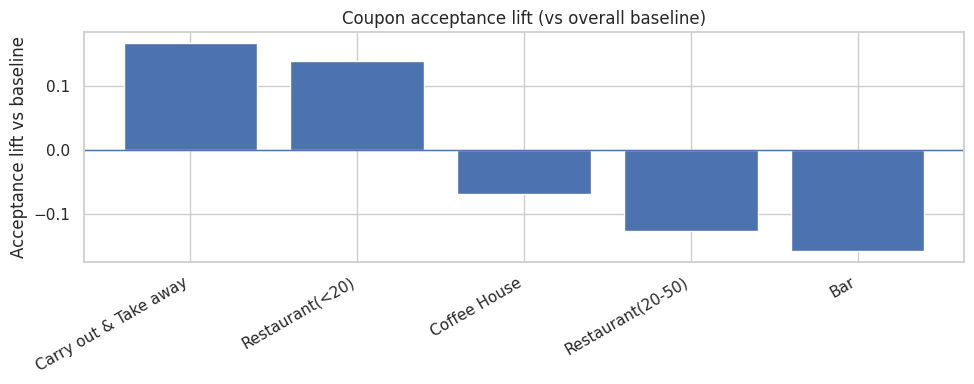

In [27]:
plt.figure(figsize=(10,4))
plt.bar(lift_coupon['coupon'], lift_coupon['lift_vs_baseline'])
plt.axhline(0, linewidth=1)
plt.xticks(rotation=30, ha='right')
plt.ylabel('Acceptance lift vs baseline')
plt.title('Coupon acceptance lift (vs overall baseline)')
plt.tight_layout()
plt.show()

## 4) Bar coupon deep-dive (prompt-driven)

We focus on Bar coupons and answer the acceptance questions using consistent filters.

### Convenience: convert age to numeric
`age` is stored as categories like `below21`, `21`, ..., `50plus`.
We map them to a numeric proxy to support comparisons (simple + transparent).

In [28]:
def age_to_num(a):
    if pd.isna(a):
        return np.nan
    if a == 'below21':
        return 20
    if a == '50plus':
        return 50
    try:
        return int(a)
    except:
        return np.nan

bar = clean[clean['coupon'] == 'Bar'].copy()
bar['age_num'] = bar['age'].apply(age_to_num)

bar.shape, bar['Y'].mean()

((2017, 26), np.float64(0.41001487357461575))

### 4.1 Compare acceptance: frequent bar-goers vs others

Define **bar-goers more than once/month** as `Bar ∈ {1~3, 4~8, gt8}`.


In [29]:
more_than_once = bar['Bar'].isin(['1~3','4~8','gt8'])

rate_more = bar.loc[more_than_once, 'Y'].mean()
rate_other = bar.loc[~more_than_once, 'Y'].mean()
rate_more, rate_other

(np.float64(0.6879194630872483), np.float64(0.29345531315974666))

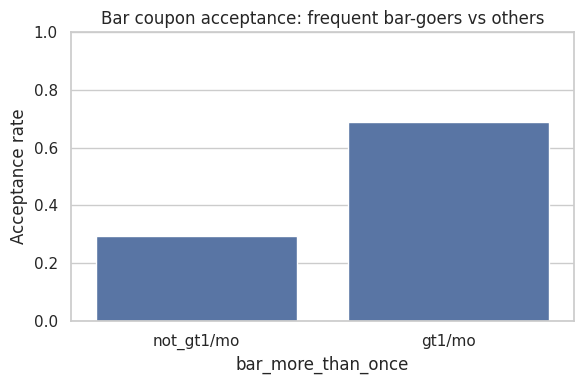

In [30]:
tmp = bar.copy()
tmp['bar_more_than_once'] = np.where(more_than_once, 'gt1/mo', 'not_gt1/mo')

plt.figure(figsize=(6,4))
sns.barplot(data=tmp, x='bar_more_than_once', y='Y', errorbar=None)
plt.ylim(0,1)
plt.title('Bar coupon acceptance: frequent bar-goers vs others')
plt.ylabel('Acceptance rate')
plt.tight_layout()
plt.show()

### 4.2 Compare acceptance: bar-goers (>1/mo) and age > 25 vs everyone else

This creates a clear behavioral segment (frequency + age).

In [31]:
seg = more_than_once & (bar['age_num'] > 25)
rate_seg = bar.loc[seg, 'Y'].mean()
rate_rest = bar.loc[~seg, 'Y'].mean()
rate_seg, rate_rest

(np.float64(0.6952380952380952), np.float64(0.33500313087038197))

### 4.3 Multi-condition comparison (prompt #6)

Compute acceptance for the following groups:
- A) go to bars >1/mo, passengers are **not** Kid(s), and **not** widowed
- B) go to bars >1/mo and age < 30
- C) go to cheap restaurants (>4/mo) and income < $50K


In [32]:
lt50 = bar['income'].isin(['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999'])

condA = more_than_once & (bar['passanger'] != 'Kid(s)') & (bar['maritalStatus'] != 'Widowed')
condB = more_than_once & (bar['age_num'] < 30)
condC = bar['RestaurantLessThan20'].isin(['4~8','gt8']) & lt50

rates = pd.Series({
    'All Bar coupons': bar['Y'].mean(),
    'A: Bar>1/mo + no kids passenger + not widowed': bar.loc[condA,'Y'].mean(),
    'B: Bar>1/mo + age<30': bar.loc[condB,'Y'].mean(),
    'C: CheapRest>4/mo + income<50K': bar.loc[condC,'Y'].mean()
}).sort_values(ascending=False)

rates

,0
B: Bar>1/mo + age<30,0.721739
A: Bar>1/mo + no kids passenger + not widowed,0.713249
C: CheapRest>4/mo + income<50K,0.453488
All Bar coupons,0.410015


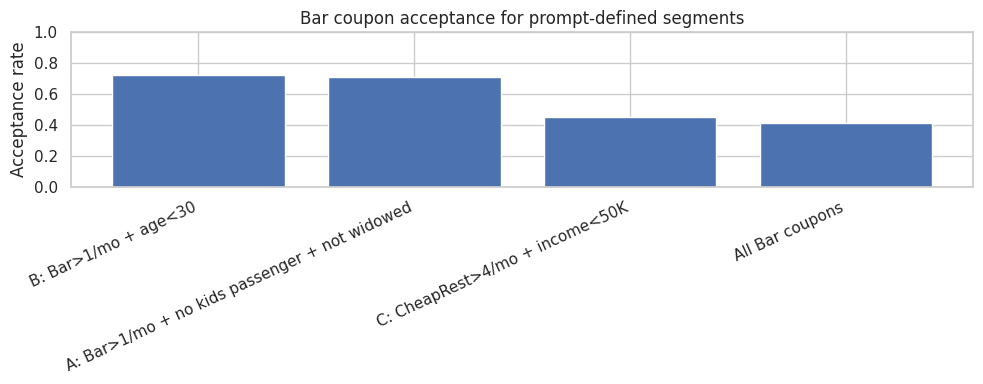

In [33]:
plt.figure(figsize=(10,4))
plt.bar(rates.index, rates.values)
plt.xticks(rotation=25, ha='right')
plt.ylim(0,1)
plt.ylabel('Acceptance rate')
plt.title('Bar coupon acceptance for prompt-defined segments')
plt.tight_layout()
plt.show()

### 4.4 Hypothesis (prompt #7)

Based on the segment acceptance rates above, a practical hypothesis is:

- **Behavior dominates:** people who already frequent bars (>1/mo) are much more likely to accept Bar coupons.
- **Context matters:** acceptance is highest when conditions suggest an adult social outing (no kid passengers, not widowed) and younger adults.
- The **cheap-restaurant + <50K** segment shows a smaller lift, suggesting the Bar coupon is less aligned with that group than true bar-going behavior.


## 5) Independent investigation — Coffee House coupons

To go beyond the Bar example, we examine Coffee House coupons using the same lift-first approach.
We focus on **CoffeeHouse visit frequency** and **time of day**.


In [34]:
coffee = clean[clean['coupon'] == 'Coffee House'].copy()
coffee['Y'].mean(), coffee.shape

(np.float64(0.49924924924924924), (3996, 25))

In [35]:
# Acceptance by coffee-house visit frequency
coffee_rate = coffee.groupby('CoffeeHouse')['Y'].mean().sort_values(ascending=False)
coffee_rate

,Y
CoffeeHouse,
4~8,0.685874
gt8,0.657895
1~3,0.647793
less1,0.481860
unknown,0.458333
never,0.188781


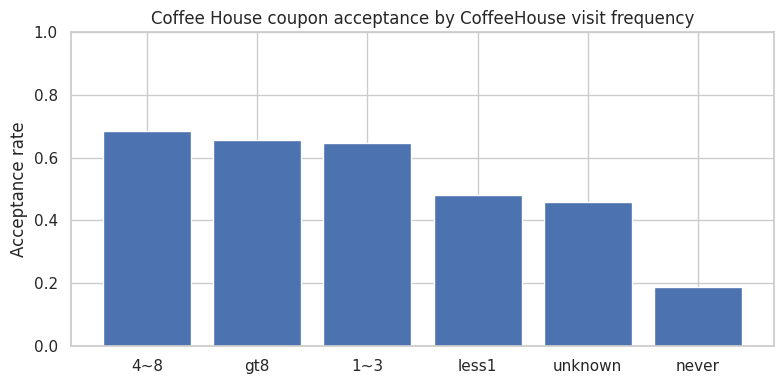

In [36]:
plt.figure(figsize=(8,4))
plt.bar(coffee_rate.index.astype(str), coffee_rate.values)
plt.ylim(0,1)
plt.ylabel('Acceptance rate')
plt.title('Coffee House coupon acceptance by CoffeeHouse visit frequency')
plt.tight_layout()
plt.show()

In [37]:
# Acceptance by time of day for Coffee House coupons
coffee_time = coffee.groupby('time')['Y'].mean().sort_values(ascending=False)
coffee_time

,Y
time,
10AM,0.640712
2PM,0.547859
7AM,0.445783
10PM,0.424242
6PM,0.412626


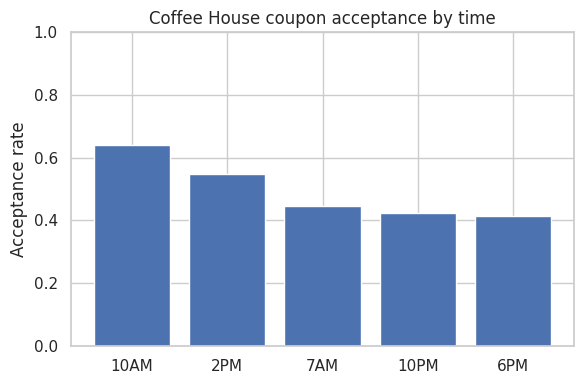

In [38]:
plt.figure(figsize=(6,4))
plt.bar(coffee_time.index.astype(str), coffee_time.values)
plt.ylim(0,1)
plt.ylabel('Acceptance rate')
plt.title('Coffee House coupon acceptance by time')
plt.tight_layout()
plt.show()

## 6) Findings and recommendations

### Key findings (fill numbers from output above)
- Baseline coupon acceptance rate is shown in Section 2.
- Bar coupon acceptance is lower than baseline overall, but rises sharply for frequent bar-goers (>1/mo).
- For Bar coupons, the strongest lift appears in segments that indicate an adult social context (no kid passengers, not widowed) and younger adults.
- For Coffee House coupons, acceptance increases with higher CoffeeHouse visit frequency and varies by time of day.

### Recommendations
- **Target Bar coupons** toward frequent bar-goers, especially during times and contexts associated with adult social trips.
- **Reduce spend on Bar coupons** for segments unlikely to accept (non-bar-goers) and reallocate to higher performing coupon types.
- For Coffee House coupons, emphasize **timing** (e.g., morning/afternoon) and frequent visitors for best conversion.

### Next steps
- Add a simple model (logistic regression) to quantify feature importance.
- Explore interactions (coupon × time × destination) and validate with a hold-out set.
